In [1]:
# awk 'NR<=100000{print $0}' train.csv > 10萬筆測試資料.xlsx
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

## Load Data

In [2]:
# 55423856筆資料
df = pd.read_csv("/Volumes/transcend/大檔案/Taxi/NYT/10萬筆測試訓練資料.csv")

In [3]:
df['key'] = pd.to_datetime(df['key'], format='%Y-%m-%d %H:%M:%S')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'].str.replace('UTC',''), format='%Y-%m-%d %H:%M:%S')

In [4]:
df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 8 columns):
key                  99999 non-null datetime64[ns]
fare_amount          99999 non-null float64
pickup_datetime      99999 non-null datetime64[ns]
pickup_longitude     99999 non-null float64
pickup_latitude      99999 non-null float64
dropoff_longitude    99999 non-null float64
dropoff_latitude     99999 non-null float64
passenger_count      99999 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 6.1 MB


## EDA

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/System/Library/Fonts/STHeiti Light.ttc")

In [44]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,11.354708,-72.494667,39.914473,-72.490952,39.919044,1.673827
std,9.716809,10.693986,6.225716,10.471438,6.213457,1.300175
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768164,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


### 乘客數量分佈

In [6]:
df['passenger_count'].value_counts()

1    69618
2    14561
5     7034
3     4289
4     2091
6     2040
0      366
Name: passenger_count, dtype: int64

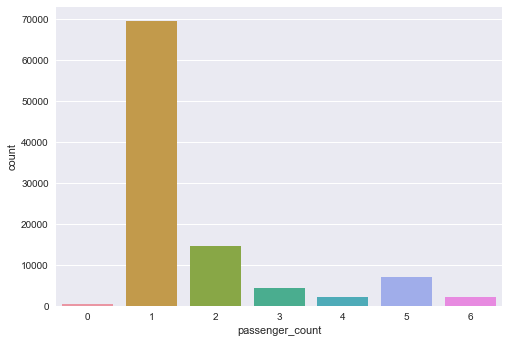

In [46]:
sns.countplot(data=df,x='passenger_count')
plt.show()

In [7]:
# 載到鬼?
df[df['passenger_count']==0].head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,2015-06-02 23:16:15.000000120,34.0,2015-06-02 23:16:15,-73.974899,40.751095,-73.908546,40.881878,0
566,2012-01-28 21:33:18.000000200,4.9,2012-01-28 21:33:18,-73.955322,40.782840,-73.955797,40.773673,0
678,2012-02-27 07:24:20.000000300,6.5,2012-02-27 07:24:20,-73.983397,40.738183,-73.971395,40.758023,0


### 價錢分佈

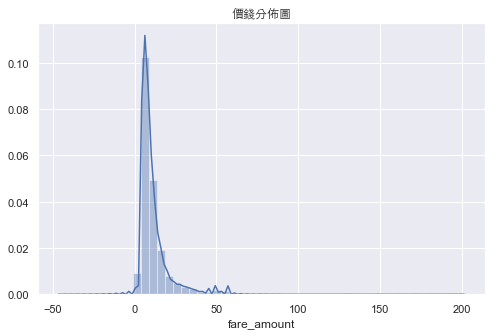

In [11]:
x = df['fare_amount']
sns.distplot(x)
plt.title('價錢分佈圖',fontproperties=font,size=12)
plt.gcf().set_size_inches(8,5)
plt.show()

In [115]:
# 價錢負的?
df[df['fare_amount']<0].head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,2010-03-09 23:37:10.000000500,-2.9,2010-03-09 23:37:10,-73.789450,40.643498,-73.788665,40.641952,1
2486,2015-03-22 05:14:27.000000100,-2.5,2015-03-22 05:14:27,-74.000031,40.720631,-73.999809,40.720539,1
13032,2013-08-30 08:57:10.000000200,-3.0,2013-08-30 08:57:10,-73.995062,40.740755,-73.995885,40.741357,4


In [15]:
# 去除價錢小於0
df2 = df[df['fare_amount']>0]
df2 = df2.reset_index(drop=True)

### 限制經緯度範圍
有outlier

In [16]:
# 三筆outlier，5686，92310
df2 = df2[(df2['pickup_latitude']<90)&(df2['pickup_latitude']>-90)&(df2['dropoff_latitude']<90)&(df2['dropoff_latitude']>-90)&(df2['pickup_longitude']<180)&(df2['pickup_longitude']>-180)&(df2['dropoff_longitude']<180)&(df2['dropoff_longitude']>-180)]
df2 = df2.reset_index(drop=True)

In [122]:
len(df2)

99984

### 新增距離欄位

In [12]:
import geopy.distance
from math import sin, cos, sqrt, atan2, radians

### Test

In [30]:
# approximate radius of earth in km
R = 6373.0

lat1 = radians(52.2296756)
lon1 = radians(21.0122287)
lat2 = radians(52.406374)
lon2 = radians(16.9251681)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance)
print("Should be:", 278.546, "km")

Result: 278.54558935106695
Should be: 278.546 km


In [35]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.vincenty(coords_1, coords_2).km)

279.35290160386563


/Users/andy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


In [17]:
dis = []
for i in tqdm_notebook(range(len(df2))):
    dis.append(geopy.distance.vincenty((df2['pickup_latitude'][i],df2['pickup_longitude'][i]),(df2['dropoff_latitude'][i],df2['dropoff_longitude'][i])).km)
df2['distance'] = pd.DataFrame(dis)

/Users/andy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  app.launch_new_instance()


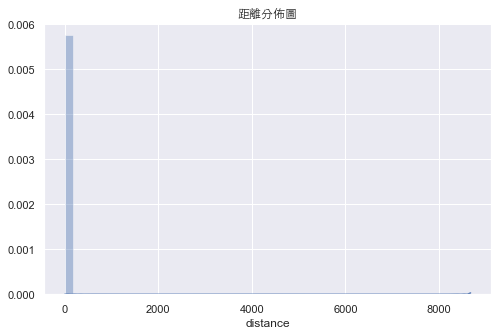

In [18]:
x = df2['distance']
sns.distplot(x)
plt.title('距離分佈圖',fontproperties=font,size=12)
plt.gcf().set_size_inches(8,5)
plt.show()

In [21]:
# 有outlier
df2[df2['distance']>8000].head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00,0.000000,0.000000,-74.005433,40.726685,2,8667.655928
1260,2011-03-10 20:25:00.000000490,5.7,2011-03-10 20:25:00,-73.973907,40.754743,0.000000,0.000000,2,8665.602660
2396,2012-06-24 17:11:10.000000100,45.0,2012-06-24 17:11:10,0.000000,0.000000,-74.010230,40.714553,2,8667.810452


In [26]:
# 限縮只取出包含testing data的經緯度範圍，(-74.5, -72.8, 40.5, 41.8)
df3 = df2[(df2['pickup_longitude']>=-74.5)&(df2['pickup_longitude']<=-72.8)&(df2['pickup_latitude']>=40.5)&(df2['pickup_latitude']<=41.8)&(df2['dropoff_longitude']>=-74.5)&(df2['dropoff_longitude']<=-72.8)&(df2['dropoff_latitude']>=40.5)&(df2['dropoff_latitude']<=41.8)]
df3 = df3.reset_index(drop=True)

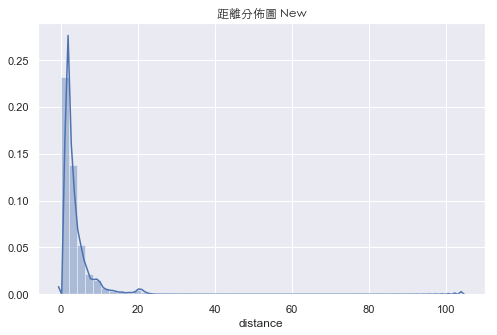

In [27]:
x = df3['distance']
sns.distplot(x)
plt.title('距離分佈圖 New',fontproperties=font,size=12)
plt.gcf().set_size_inches(8,5)
plt.show()

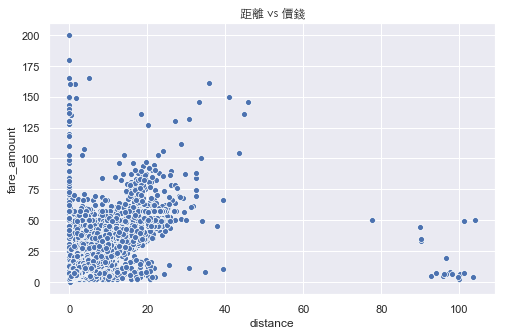

In [29]:
sns.scatterplot(data=df3, x='distance', y='fare_amount')
plt.gcf().set_size_inches(8,5)
plt.title("距離 vs 價錢",fontproperties=font,size=12)
plt.show()

### 取出時間

In [31]:
df3['year'] = df3['pickup_datetime'].dt.year
df3['month'] = df3['pickup_datetime'].dt.month
df3['weekday'] = df3['pickup_datetime'].dt.weekday
df3['weekday'] = df3['weekday'].replace([0, 1, 2, 3, 4, 5, 6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
df3['hour'] = df3['pickup_datetime'].dt.hour

In [34]:
df3.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,weekday,hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,2009,6,Monday,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,2010,1,Tuesday,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,2011,8,Thursday,0


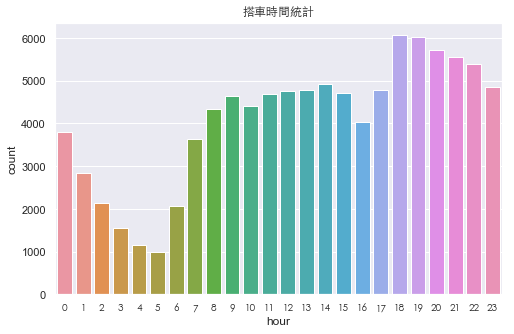

In [23]:
sns.countplot(data=df3, x='hour')
plt.xticks(fontproperties=font,size=10)
plt.title("搭車時間統計",fontproperties=font,size=12)
plt.gcf().set_size_inches(8,5)
plt.show()

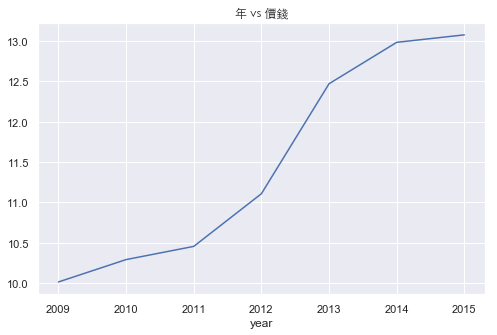

In [28]:
# 車資隨時間上漲
df_yf = df3.groupby(['year'])['fare_amount'].mean()
sns.lineplot(x=df_yf.index, y=df_yf.values)
plt.title("年 vs 價錢", fontproperties=font,size=12)
plt.gcf().set_size_inches(8,5)
plt.show()